# Flower Image Classification with CNNs

In [1]:
# Update to 2.15 first
! pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes

In [2]:
# Download the image data to a flower_photos folder
import os
from six.moves import urllib

FLOWERS_DIR = 'flower_photos' # Download to this directory from the download URL

def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz') # Like ```urlopen```.
    !tar xfz flower_photos.tgz
  print(f'Flower photos are located in the {FLOWERS_DIR} folder')

download_images()

Flower photos are located in the flower_photos folder


In [3]:
# Extract all filepaths iteratively
from itertools import repeat

categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object
# Also track the flower types as y_labels
fnames = []
y_labels = []
for category in categories:
    flower_folder = os.path.join(FLOWERS_DIR, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    type_count = len(full_path)
    print(f'{type_count} {category} files')
    fnames.append(full_path)
    y_labels.extend(list(repeat(category, type_count)))

633 daisy files
898 dandelion files
641 roses files
699 sunflowers files
799 tulips files


In [4]:
# Create an image preprocessor
import numpy as np
import cv2

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.
        params:
            data
                list of unprocessed images

        returns:
            X
                numpy array of preprocessed image data
        """
        "Resize a color image and min/max transform the image"

        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.

        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels].
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

In [5]:
# Preprocess the images
preprocessed_image_data = [preprocessor(x) for x in fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]]

In [6]:
# Object needs to be an array rather than a list for Keras
# vstack converts above list to array object
X = np.vstack(preprocessed_image_data)

print(f'X.shape: {X.shape}')
print(f'Image Count: {len(preprocessed_image_data)}')
print(f'Image Size: {preprocessed_image_data[0].shape}')
print(f'Image Values: {preprocessed_image_data[0].min()} to {np.round(preprocessed_image_data[0].max(),1)}')

X.shape: (3670, 192, 192, 3)
Image Count: 3670
Image Size: (1, 192, 192, 3)
Image Values: 0.0 to 1.0


In [7]:
y_labels[:20]

['daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy']

In [8]:
# One-hot encode the y_labels
import pandas as pd
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
3665,False,False,False,False,True
3666,False,False,False,False,True
3667,False,False,False,False,True
3668,False,False,False,False,True


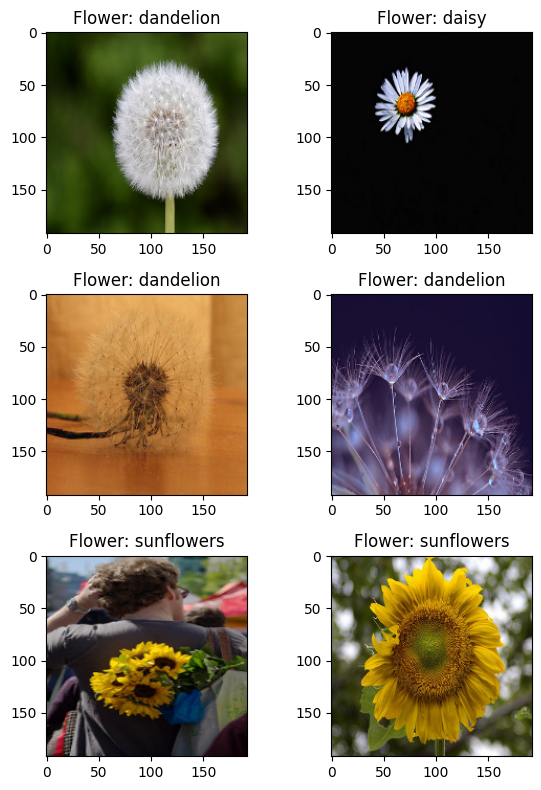

In [9]:
# Visualize some of the images
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(3, 2)
fig.set_size_inches(6, 8)
for i in range(3):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])

plt.tight_layout()

In [10]:
# train_test_split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=1987)

In [11]:
# Build a CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
import tensorflow as tf

with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(100, activation='relu')) # One fully-connected layer of 100 neurons.

        model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the model to the training set
        model.fit(X_train, y_train, epochs=1, verbose=1, validation_data=(X_test, y_test))

92/92 [==============================] - 10s 59ms/step - loss: 1.6589 - accuracy: 0.3767 - val_loss: 1.1578 - val_accuracy: 0.5218


In [12]:
# Generate list of predicted labels

# Get the model prediction probabilities
y_pred = model.predict(X_test)
print(y_pred.shape)

# Take the class with the highest probability for each observation
y_pred = y_pred.argmax(axis=1)
print(y_pred.shape)

# Map onto the class labels
y_pred_labels = [y_test.columns[i] for i in y_pred]
print(y_pred[:10])
print(y_pred_labels[:10])

23/23 [==============================] - 0s 11ms/step
(734, 5)
(734,)
[3 3 3 1 4 1 0 4 3 1]
['sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'dandelion', 'daisy', 'tulips', 'sunflowers', 'dandelion']
